# Studying Maximum Rainfall

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from pprint import pprint

from ts.utility import Utility
from ts.experimental import GeneralizedExtremeValueDistribution, GevEstimate, Pso
from ts.decompose import ClassicalDecompose, StlDecompose
from ts.model import DeepNN

## Load Dataset

In [2]:
rainfall_df = pd.read_csv('../datasets/rainfall-data.csv')[['YEAR', 'MN', 'DT', '..R/F']]
rainfall_df

,YEAR,MN,DT,..R/F
0,1970,1,1,0.0
1,1970,1,2,3.2
2,1970,1,3,0.0
3,1970,1,4,0.0
4,1970,1,5,0.0
...,...,...,...,...
17647,2018,4,26,0.0
17648,2018,4,27,2.1
17649,2018,4,28,0.0
17650,2018,4,29,0.0


## Plot Entire Data

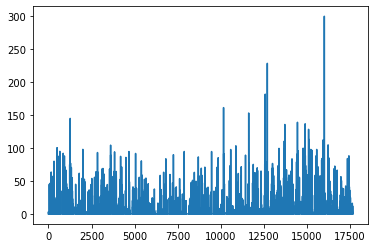

In [3]:
_ = plt.plot(rainfall_df['..R/F'].to_numpy())

## Helper Functions

In [4]:
def get_most_likely_point(shape, location, scale, low, high, num_particles, num_iter):
    
    def min_func(x):
        
        log_lkhd = GeneralizedExtremeValueDistribution\
            .logLikelihood(shape, location, scale, np.array([x]))
        
        return -log_lkhd if log_lkhd is not None else np.inf
    
    init_pos = Pso.computeInitialPos([(low, high)], num_particles)
    
    return Pso.pso(min_func, init_pos, numIterations=num_iter)

In [5]:
def get_return_level(shape, location, scale, prob):
    
    if shape == 0:
        return location - scale * np.log(-np.log(1 - prob))
        
    return location - (scale / shape) * (1 - ((-np.log(1 - prob)) ** (-shape)))

# Fitting GEV to Monthly Maximum

## Computing monthly maximum

Data Type: float64, Data Shape: (580,)

First 10 data points:
[3.2, 45.0, 0.0, 47.0, 25.2, 63.6, 39.0, 57.0, 27.0, 30.0]

Last 10 data points:
[58.0, 54.2, 88.2, 41.1, 15.2, 24.8, 0.0, 12.6, 14.8, 16.2]


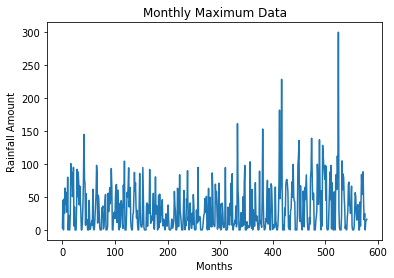

In [6]:
month_max_series = [rainfall_df.iloc[0]['..R/F']]
prev_month = rainfall_df.iloc[0]['MN']

for _, row in rainfall_df.iloc[1:].iterrows():
    
    if row['MN'] == prev_month:
        month_max_series[-1] = max(month_max_series[-1], row['..R/F'])
        
    else:
        month_max_series.append(row['..R/F'])
        
    prev_month = row['MN']
    
month_max_series = np.array(month_max_series)

print(f'Data Type: {month_max_series.dtype}, Data Shape: {month_max_series.shape}\n')
print('First 10 data points:')
pprint(list(month_max_series[:10]))
print('')

print('Last 10 data points:')
pprint(list(month_max_series[-10:]))

plt.plot(month_max_series)
plt.title('Monthly Maximum Data')
plt.xlabel('Months')
plt.ylabel('Rainfall Amount')
plt.show()

## 1) Fitting GEV to monthly data using ML estimation (PSO)

### Fit GEV params using PSO on data

Shape Parameter: 1.1356358687565151 
Location Parameter: 7.486400061686653 
Scale Parameter: 12.032791739462688 
Log Likelihood: -2689.128555090656


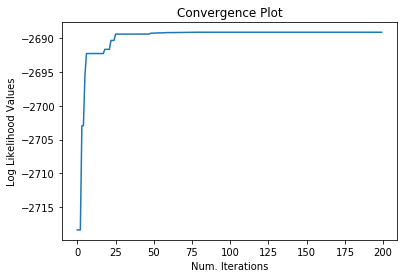

In [7]:
params, max_log_likelihood, max_log_likelihood_vals = GevEstimate.psoMethod(
    month_max_series,
    Pso.computeInitialPos([(-10, 10), (0, 100), (1, 10)], 200),
    numIterations=200
)

shape, location, scale = params
print(f'Shape Parameter: {shape} \n'
    + f'Location Parameter: {location} \n'
    + f'Scale Parameter: {scale} \n'
    + f'Log Likelihood: {max_log_likelihood}')

plt.plot(max_log_likelihood_vals)
plt.title('Convergence Plot')
plt.xlabel('Num. Iterations')
plt.ylabel('Log Likelihood Values')
plt.show()

### Plot PDF and CDF

/Users/ahmed/Programming/Project/Forecast/ts/experimental/genextreme.py:76: RuntimeWarning: invalid value encountered in power
  / self.scaleParam


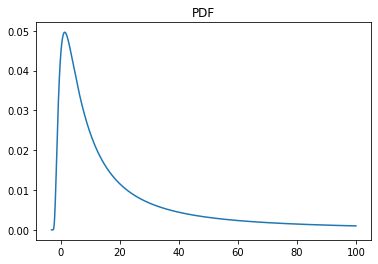

/Users/ahmed/Programming/Project/Forecast/ts/experimental/genextreme.py:92: RuntimeWarning: invalid value encountered in power
  return np.exp(- ((1 + self.shapeParam * transformData) ** (-1. / self.shapeParam)))


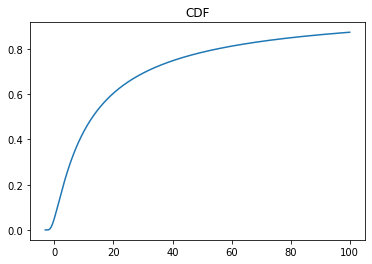

In [8]:
x = np.linspace(-5, 100, 10000)

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).pdf(x)
)
plt.title('PDF')
plt.show()

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).cdf(x)
)
plt.title('CDF')
plt.show()

### Compute Return Levels for Input Probabilities

Given p, compute the value z such that probability for exceeding
z in the next month is p. z is called the p - return level for a
particular p.

In [9]:
prob = float(input('Enter Probability p: '))
print('Return Level for p = %0.3f is %0.3f'
      %(prob, get_return_level(shape, location, scale, prob)))

Enter Probability p: 0.5
Return Level for p = 0.500 is 12.956


### Get the point with the highest probability density

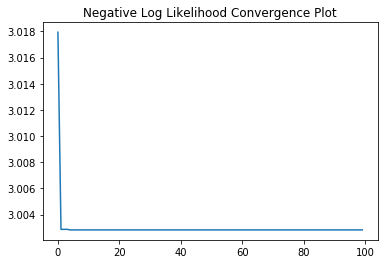

Point with the highest density: 1.3669049190508975
Negative Log Likelihood of this point: 3.0028268972691703


In [10]:
most_likely_point, min_neg_log_lkhd, lkhd_vals \
    = get_most_likely_point(shape, location, scale, 20, 300, 200, 100)

plt.plot(lkhd_vals)
plt.title('Negative Log Likelihood Convergence Plot')
plt.show()

print(f'Point with the highest density: {most_likely_point[0]}\n'
    + f'Negative Log Likelihood of this point: {min_neg_log_lkhd}')

## 2) Fitting GEV to trend and seasonality removed data

### Decompose the time series into trend, seasonality and remainder components

In [11]:
trend_series, seasonality_series, remainder_series = StlDecompose\
    .decompose(np.expand_dims(month_max_series, axis=1), 
        period=12, seasonal=101, robust=True)

### Plot trend, seasonality and remainder components

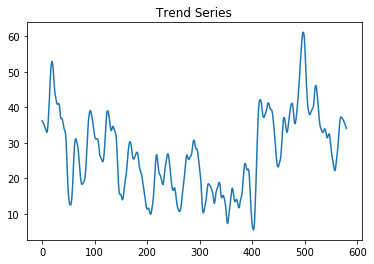

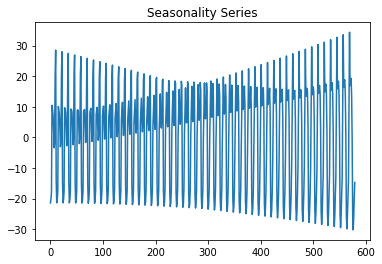

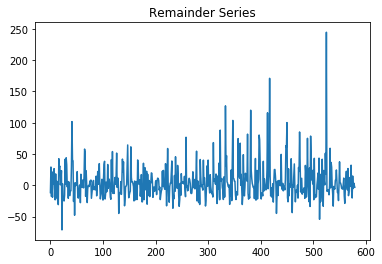

In [12]:
plt.plot(trend_series)
plt.title('Trend Series')
plt.show()

plt.plot(seasonality_series)
plt.title('Seasonality Series')
plt.show()

plt.plot(remainder_series)
plt.title('Remainder Series')
plt.show()

### Compare the inferred seasonality with actual data

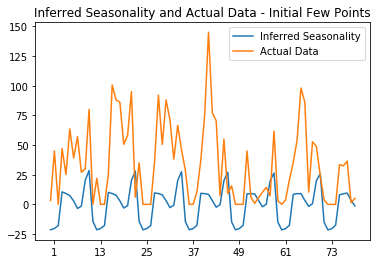

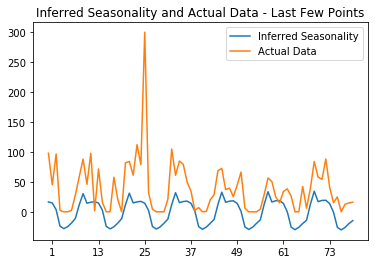

In [13]:
# Front Few Points
num_initial_points = 80

plt.plot(seasonality_series[:num_initial_points], label='Inferred Seasonality')
plt.plot(month_max_series[:num_initial_points], label='Actual Data')
plt.legend()
plt.title('Inferred Seasonality and Actual Data - Initial Few Points')
plt.xticks(np.arange(1, num_initial_points, 12))
plt.show()

# Last Few Points
num_last_points = 80

plt.plot(seasonality_series[-num_last_points:], label='Inferred Seasonality')
plt.plot(month_max_series[-num_last_points:], label='Actual Data')
plt.legend()
plt.title('Inferred Seasonality and Actual Data - Last Few Points')
plt.xticks(np.arange(1, num_last_points, 12))
plt.show()

### Fitting GEV parameters using PSO to remainder series

Shape Parameter: -0.009297863399534345 
Location Parameter: -6.466789872157957 
Scale Parameter: 20.80659732485942 
Log Likelihood: -2660.618085806681


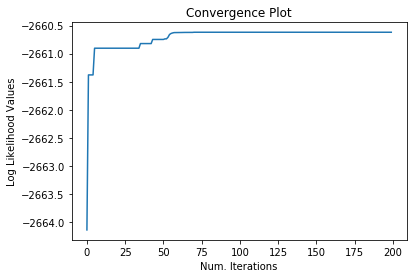

In [14]:
params, max_log_likelihood, max_log_likelihood_vals = GevEstimate.psoMethod(
    remainder_series,
    Pso.computeInitialPos([(-10, 10), (-10, 10), (5, 30)], 200),
    numIterations=200
)

shape, location, scale = params
print(f'Shape Parameter: {shape} \n'
    + f'Location Parameter: {location} \n'
    + f'Scale Parameter: {scale} \n'
    + f'Log Likelihood: {max_log_likelihood}')

plt.plot(max_log_likelihood_vals)
plt.title('Convergence Plot')
plt.xlabel('Num. Iterations')
plt.ylabel('Log Likelihood Values')
plt.show()

### Plot PDF and CDF

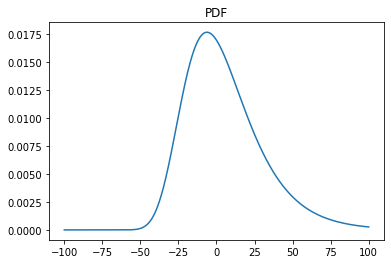

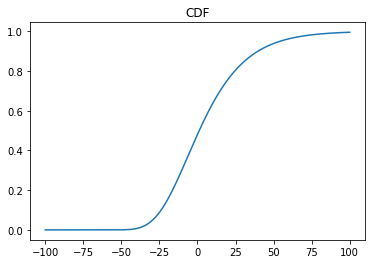

In [15]:
x = np.linspace(-100, 100, 10000)

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).pdf(x)
)
plt.title('PDF')
plt.show()

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).cdf(x)
)
plt.title('CDF')
plt.show()

### Compute Return Levels for Input Probabilities

Given p, compute the value z such that probability for exceeding z in the next month is p. z is called the p - return level for a particular p

In [16]:
prob = float(input('Enter Probability p: '))
print('Return Level for p = %0.3f is %0.3f'
      %(prob, get_return_level(shape, location, scale, prob)))

Enter Probability p: 0.5
Return Level for p = 0.500 is 1.146


### Get the point with the highest probability density

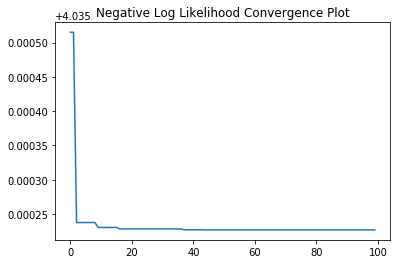

Point with the highest density: -6.2724368813822196
Negative Log Likelihood of this point: 4.035226755771079


In [17]:
most_likely_point, min_neg_log_lkhd, lkhd_vals \
    = get_most_likely_point(shape, location, scale, 20, 300, 200, 100)

plt.plot(lkhd_vals)
plt.title('Negative Log Likelihood Convergence Plot')
plt.show()

print(f'Point with the highest density: {most_likely_point[0]}\n'
    + f'Negative Log Likelihood of this point: {min_neg_log_lkhd}')